<a href="https://colab.research.google.com/github/manyachawla22/makemore-char-rnn/blob/main/makemore2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
words=open('names.txt','r').read().splitlines()
words[:8]

--2025-11-04 16:00:14--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2025-11-04 16:00:15 (8.72 MB/s) - ‘names.txt.1’ saved [228145/228145]



['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

# encode/decode
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])


In [ ]:
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

n = int(0.9 * len(X))  # 90% training data
Xtr, Ytr = X[:n], Y[:n]  # Training data
Xdev, Ydev = X[n:], Y[n:]  # Validation data



In [ ]:
import torch
import torch.nn.functional as F

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 16), generator=g, requires_grad=True)
W1 = torch.randn((16 * block_size, 48), generator=g, requires_grad=True)
b1 = torch.randn(48, generator=g, requires_grad=True)
W2 = torch.randn((48, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

for i in range(15000):
    ix = torch.randint(0, Xtr.shape[0], (256,))  # smaller batch

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    h = F.dropout(h, p=0.3, training=True)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) + 1e-3 * ((W1**2).mean() + (W2**2).mean())

    for p in parameters:
        p.grad = None
    loss.backward()
    if i < 2000:
      lr = 0.1
    elif i < 10000:
      lr = 0.01
    else:
      lr = 0.001

    for p in parameters:
        p.data += -lr * p.grad

    if i % 500 == 0:
        with torch.no_grad():
            emb_val = C[Xdev]
            h_val = torch.tanh(emb_val.view(emb_val.shape[0], -1) @ W1 + b1)
            h_val = F.dropout(h_val, p=0.3, training=False)
            logits_val = h_val @ W2 + b2
            val_loss = F.cross_entropy(logits_val, Ydev)
            print(f"Step {i}: train_loss={loss.item():.4f}, val_loss={val_loss.item():.4f}")


Step 0: train_loss=16.3231, val_loss=13.6264
Step 500: train_loss=5.0745, val_loss=3.4627
Step 1000: train_loss=3.1390, val_loss=2.8205
Step 1500: train_loss=2.9820, val_loss=2.6125
Step 2000: train_loss=2.7049, val_loss=2.5354
Step 2500: train_loss=2.7979, val_loss=2.5282
Step 3000: train_loss=2.8330, val_loss=2.5280
Step 3500: train_loss=2.6606, val_loss=2.5173
Step 4000: train_loss=2.6355, val_loss=2.5157
Step 4500: train_loss=2.7585, val_loss=2.5034
Step 5000: train_loss=2.5473, val_loss=2.5030
Step 5500: train_loss=2.7155, val_loss=2.4971
Step 6000: train_loss=2.7540, val_loss=2.4910
Step 6500: train_loss=2.3995, val_loss=2.4899
Step 7000: train_loss=2.7162, val_loss=2.4872
Step 7500: train_loss=2.7591, val_loss=2.4817
Step 8000: train_loss=2.7795, val_loss=2.4775
Step 8500: train_loss=2.4781, val_loss=2.4756
Step 9000: train_loss=2.7116, val_loss=2.4685
Step 9500: train_loss=2.5735, val_loss=2.4667
Step 10000: train_loss=2.7336, val_loss=2.4649
Step 10500: train_loss=2.7091, val_

In [ ]:
print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Ytr.min().item(), Ytr.max().item())
print(Ydev.min().item(), Ydev.max().item())


torch.Size([205331, 3]) torch.Size([205331])
torch.Size([22815, 3]) torch.Size([22815])
0 26
0 26


In [ ]:
'''If you used one-hot encoding:

“a” → [1, 0, 0, 0, …]

“b” → [0, 1, 0, 0, …]

There’s no similarity between “a” and “b” — they’re orthogonal.

But in embedding space:

“a” → [0.5, -0.1, 0.8, …]

“b” → [0.45, -0.05, 0.75, …]

Now, similar letters have similar vectors, and the network can exploit that.'''
#The embedding layer (C) turns characters into dense feature vectors (like “semantic fingerprints” of letters).

#The weight matrix (W) learns how combinations of recent letters predict the next letter.

'If you used one-hot encoding:\n\n“a” → [1, 0, 0, 0, …]\n\n“b” → [0, 1, 0, 0, …]\n\nThere’s no similarity between “a” and “b” — they’re orthogonal.\n\nBut in embedding space:\n\n“a” → [0.5, -0.1, 0.8, …]\n\n“b” → [0.45, -0.05, 0.75, …]\n\nNow, similar letters have similar vectors, and the network can exploit that.'

In [ ]:
emb = C[Xtr[ix]]                                 # (32, 4, 16)
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)  # (32, 128)
logits = h @ W2 + b2                              # (32, 27)
loss = F.cross_entropy(logits, Ytr[ix])
loss

tensor(2.3549, grad_fn=<NllLossBackward0>)

In [ ]:
emb_val = C[Xdev]
h_val = torch.tanh(emb_val.view(emb_val.shape[0], -1) @ W1 + b1)
h_val = F.dropout(h_val, p=0.3, training=False)
logits_val = h_val @ W2 + b2
val_loss = F.cross_entropy(logits_val, Ydev)
val_loss

tensor(2.4628, grad_fn=<NllLossBackward0>)

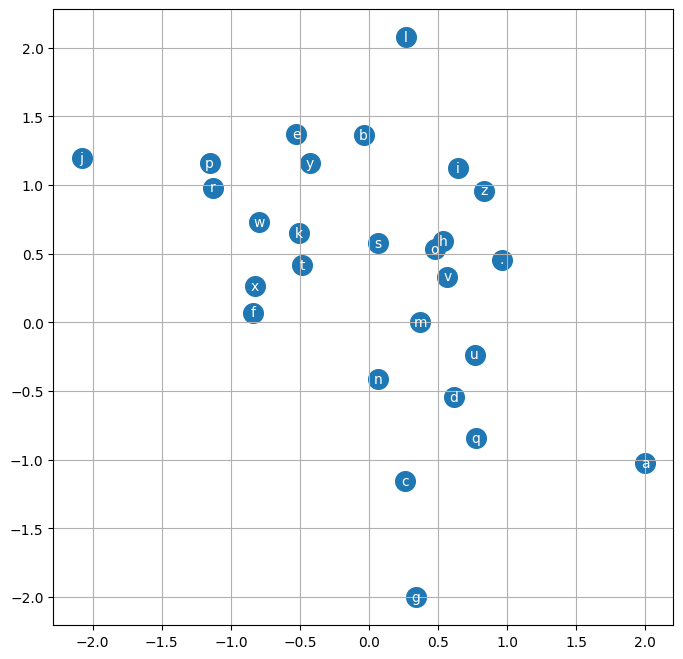

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

careah.
ami.
harihiimri.
rehty.
salassae.
rahnen.
dmesyra.
kaeei.
nelania.
chaiir.
kaleig.
dham.
elin.
essan.
salilea.
jadii.
rate.
ogiearyni.
ja.
eklirran.
